In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
from bs4 import BeautifulSoup

In [73]:
df = pd.read_csv('./data/data.csv', low_memory=False)

In [74]:
df.shape

(31335, 142)

## Null values

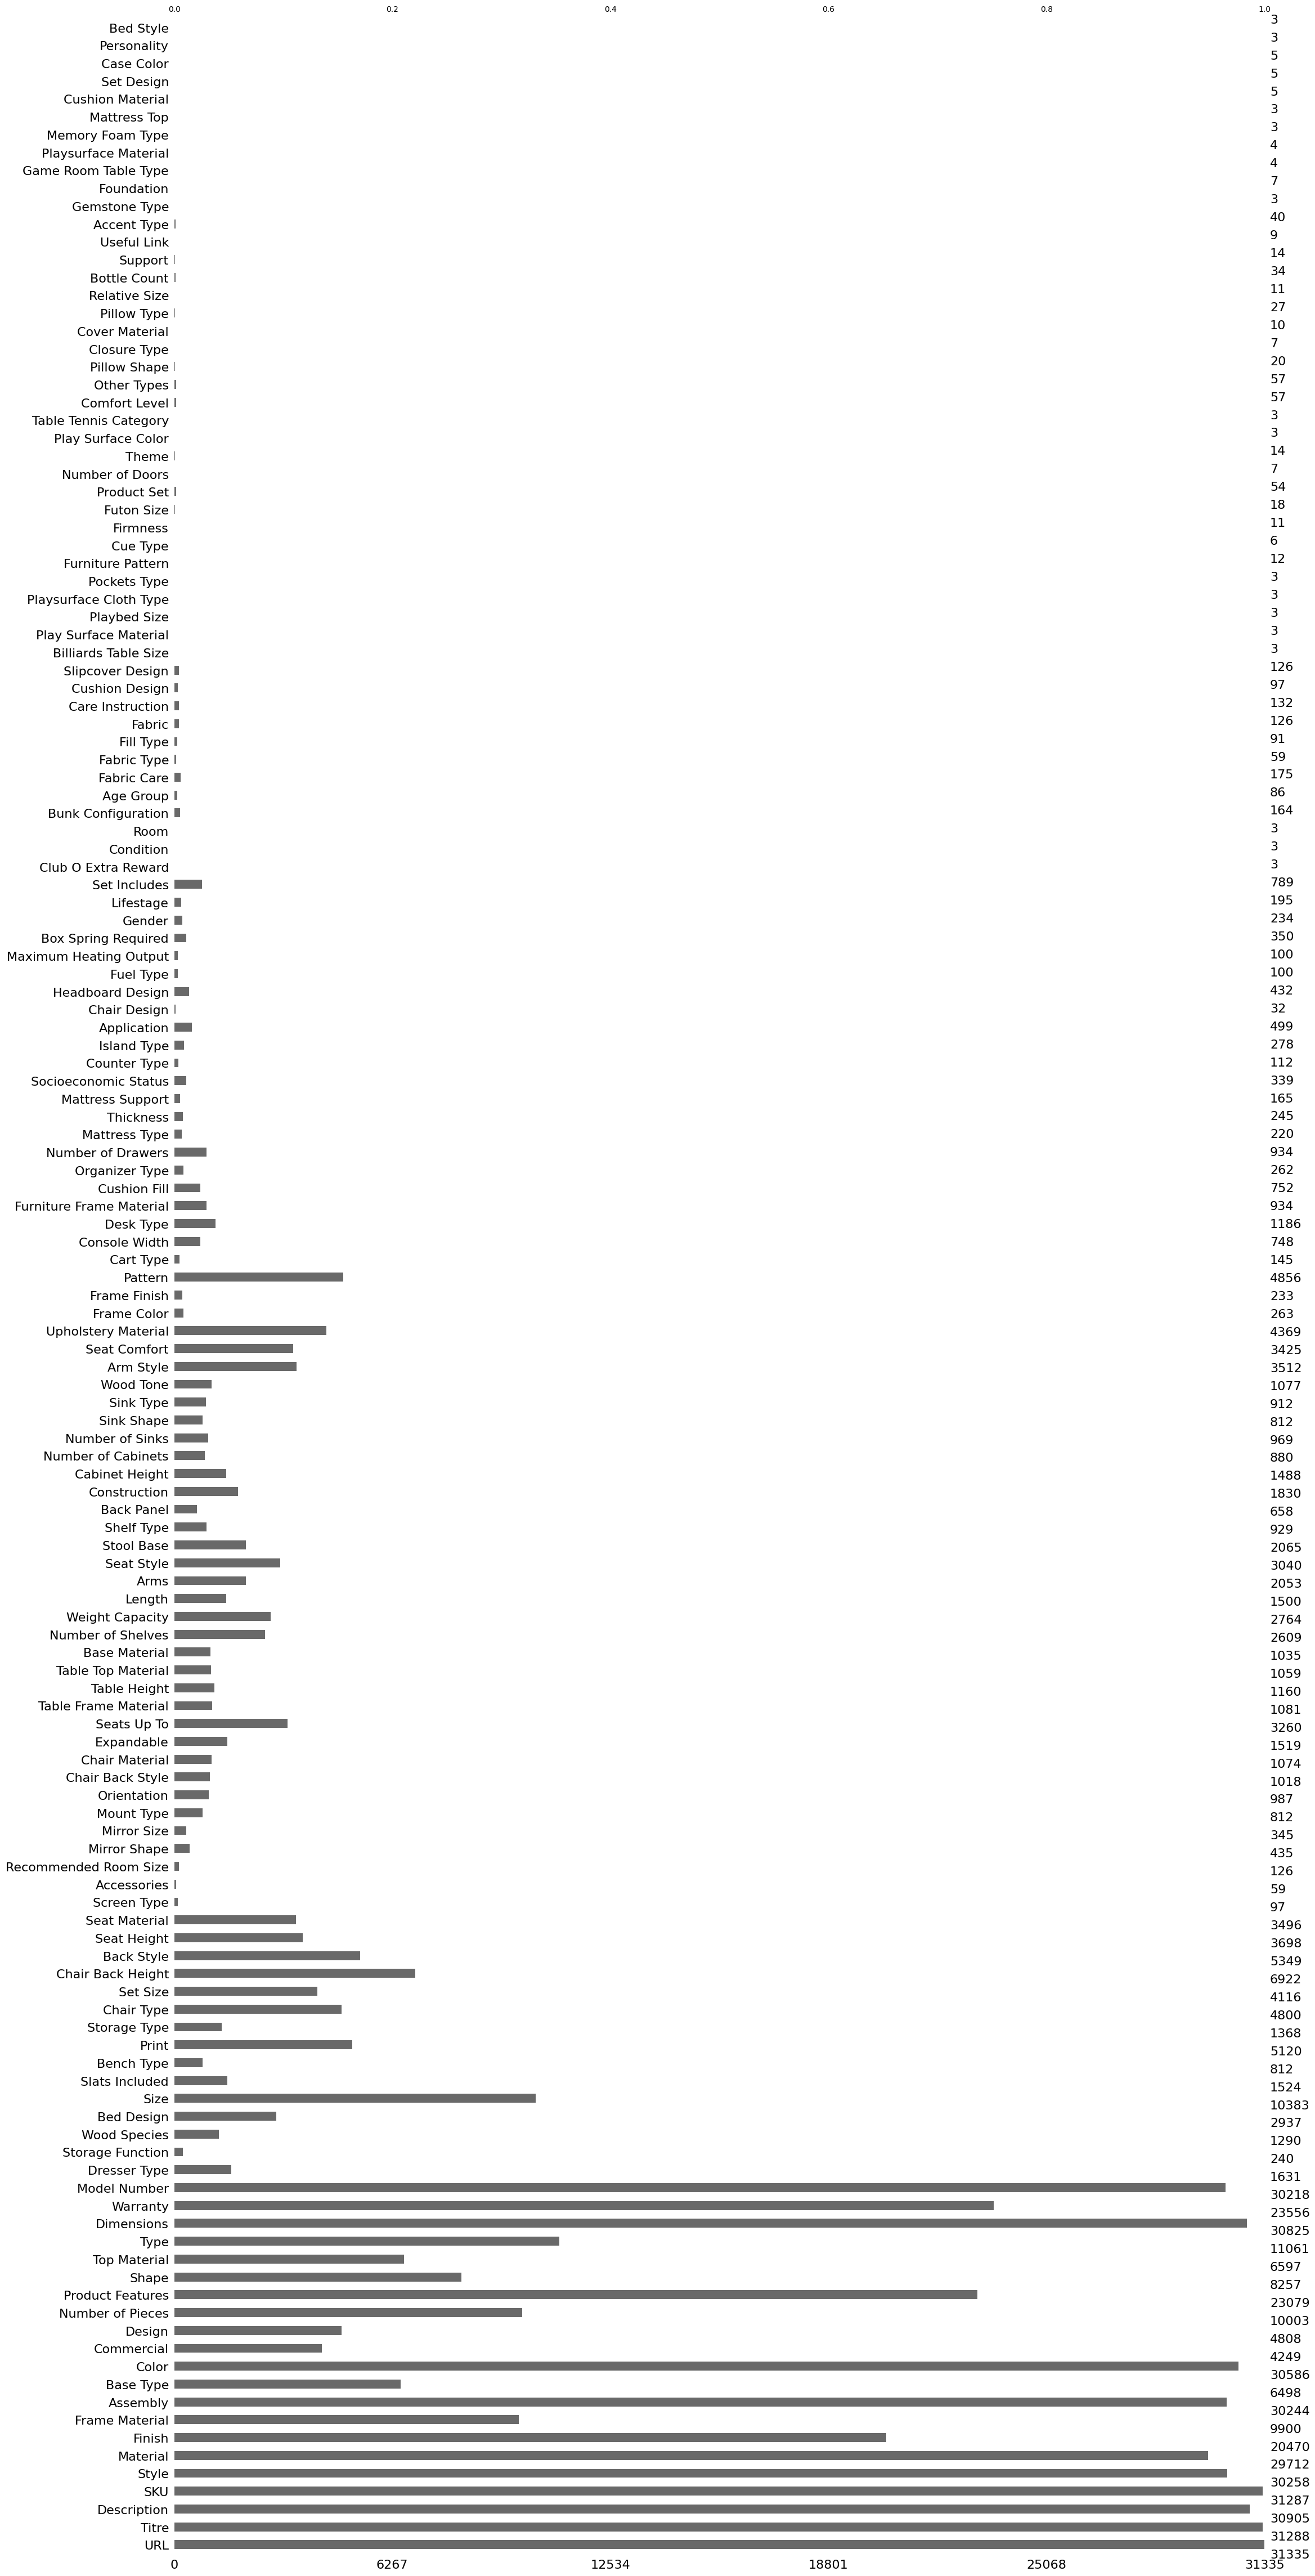

In [75]:
msno.bar(df);

In [76]:
df_clean = df.loc[:, df.isnull().mean() <= 0.5]
print(f"shape = {df_clean.shape}")
df_clean.columns.to_list()

shape = (31335, 13)


['URL',
 'Titre',
 'Description',
 'SKU',
 'Style',
 'Material',
 'Finish',
 'Assembly',
 'Color',
 'Product Features',
 'Dimensions',
 'Warranty',
 'Model Number']

In [77]:
df_clean.head(1)

,URL,Titre,Description,SKU,Style,Material,Finish,Assembly,Color,Product Features,Dimensions,Warranty,Model Number
0,https://www.overstock.com/products/39-inch-ind...,39-Inch Industrial Console Entryway Table Smal...,"Expertly crafted, this console table featuring...",42838838-000-000,"Industrial,\n M...","MDF,\n Metal",Wood Finish,Assembly Required,Brown,"Includes Hardware,\n ...",39.37 In. L X 11.81 In. W X 31.5 In. H,180 day Limited Distributor,W-YZ-JW0626


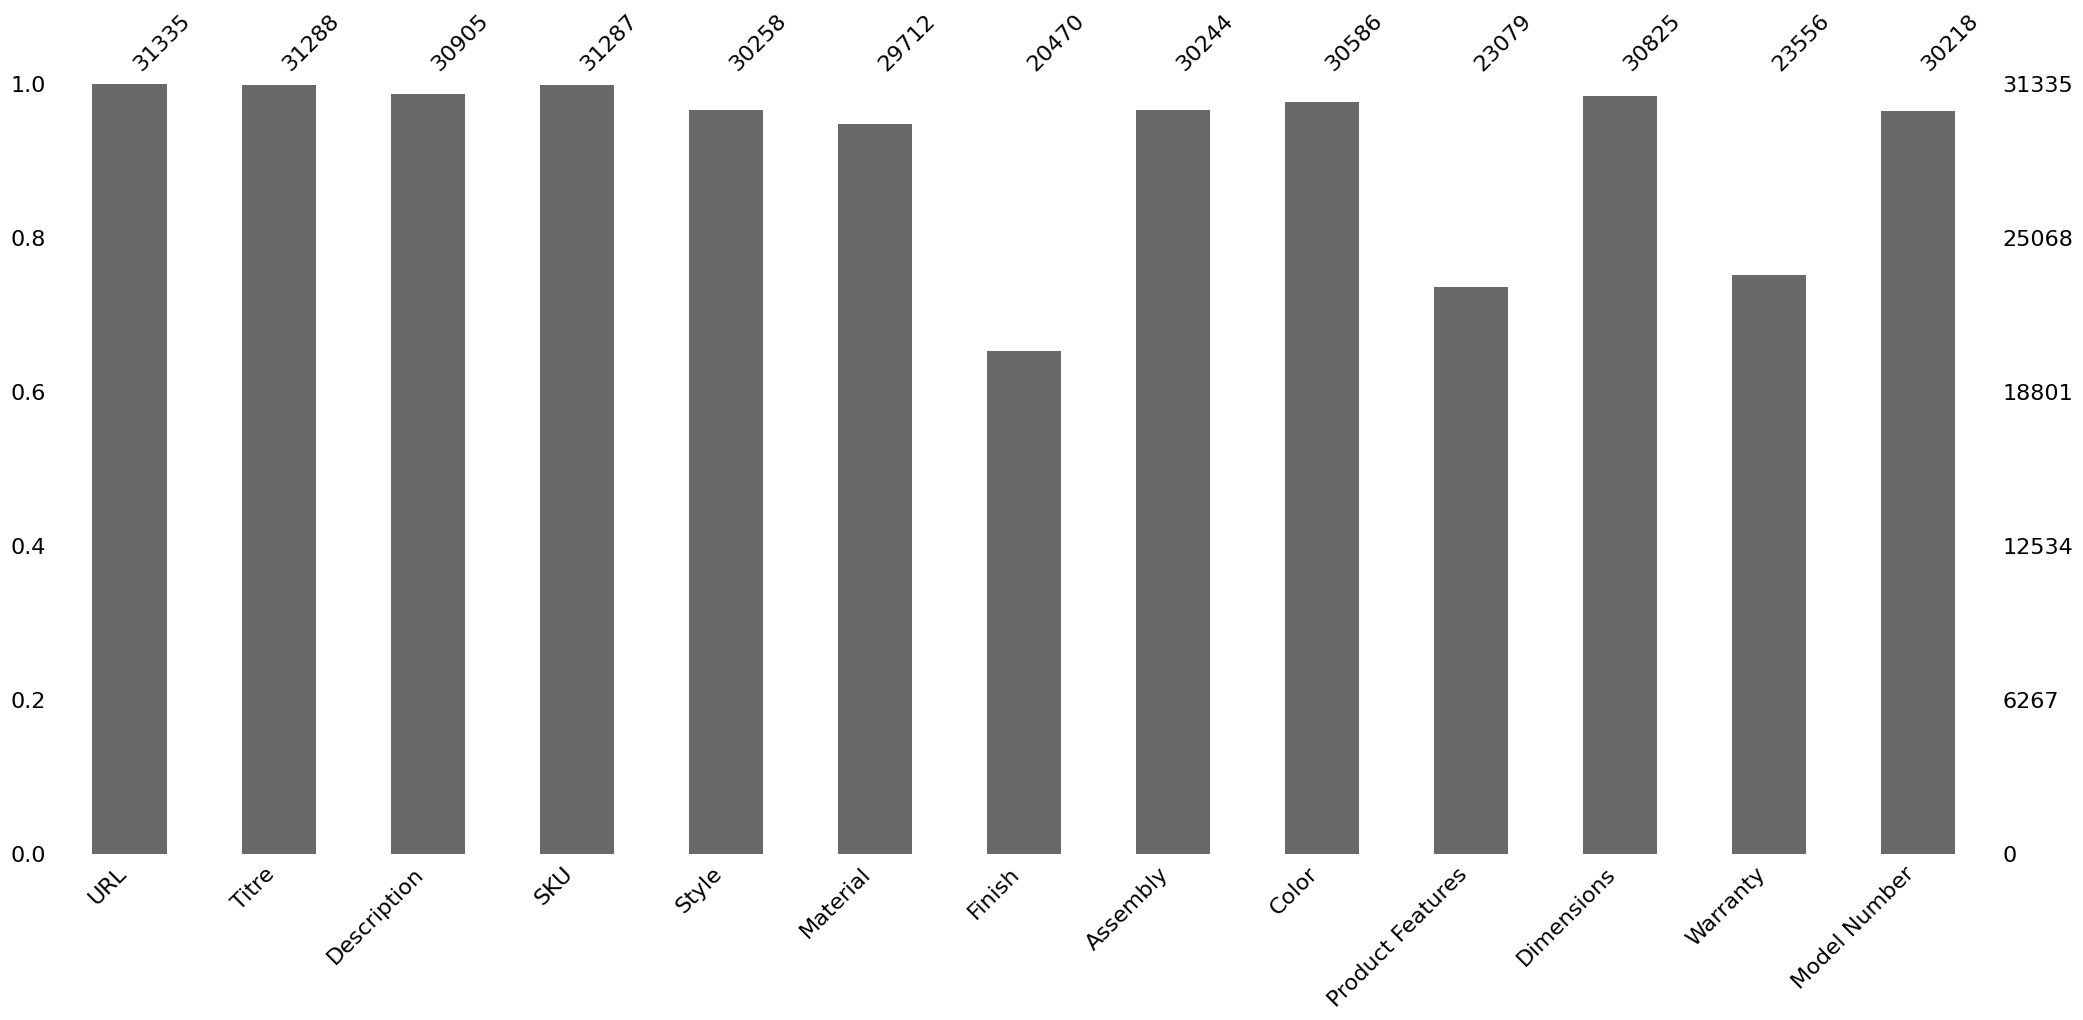

In [78]:
msno.bar(df_clean);

## Clean texts

In [79]:
df_clean.columns.to_list()

['URL',
 'Titre',
 'Description',
 'SKU',
 'Style',
 'Material',
 'Finish',
 'Assembly',
 'Color',
 'Product Features',
 'Dimensions',
 'Warranty',
 'Model Number']

In [80]:
df_clean_text = df_clean.copy()

def clean_html(text):
    if pd.isna(text):
        return text
    if text:
        return BeautifulSoup(text, "html.parser").get_text()
    return text


cols = [ 'Titre',
        'Description',
        'SKU',
        'Style',
        'Material',
        'Finish',
        'Assembly',
        'Color',
        'Product Features',
        'Dimensions']

df_clean_text[cols] = df_clean_text[cols].map(clean_html)

df_clean_text[cols] = (
    df_clean_text[cols]
    .astype(str)
    .replace(r'\n+', ' ', regex=True)
    .replace(r'\s+', ' ', regex=True)
    .apply(lambda col: col.str.strip())
)

    
df_clean_text.head()

,URL,Titre,Description,SKU,Style,Material,Finish,Assembly,Color,Product Features,Dimensions,Warranty,Model Number
0,https://www.overstock.com/products/39-inch-ind...,39-Inch Industrial Console Entryway Table Smal...,"Expertly crafted, this console table featuring...",42838838-000-000,"Industrial, Modern & Contemporary","MDF, Metal",Wood Finish,Assembly Required,Brown,"Includes Hardware, Storage",39.37 In. L X 11.81 In. W X 31.5 In. H,180 day Limited Distributor,W-YZ-JW0626
1,https://www.overstock.com/products/palace-impo...,Palace Imports 100% Solid Wood Single Wardrobe...,Add even more organization to your ample Famil...,16612403-000-002,Modern & Contemporary,"Pine, Wood","Satin, Stained",Assembled,"Black, Brown, Orange, Red, White","Includes Hardware, Solid Wood",18.0 In. W X 0.75 In. H X 28.0 In. D,1 year Limited Distributor,5657
2,https://www.overstock.com/products/boyd-sleep-...,"Boyd Sleep Lugano Wood Platform Bed Frame, Mod...",The Boyd Sleep Lugano Platform Bed Frame is a ...,43552956-000-000,Modern & Contemporary,Wood,Natural,Assembly Required,"Black, White",Includes Hardware,78.15 In. L X 56.5 In. W X 11.81 In. H,1 year Limited Manufacturer,LUGQNWH
3,https://www.overstock.com/products/origins-by-...,Origins by Alpine Nova Bench,Introducing the Nova Bench. This bench comes f...,39036109-000-001,Transitional,Mahogany,Honey Finish,Assembled,Brown,Storage,15.0 In. L X 59.0 In. W X 18.0 In. H,1 year Limited Manufacturer,110-12
4,https://www.overstock.com/products/kitchen-din...,Kitchen Dining Room Chairs Modern Dining Table...,Surround your dining space with a set of dinin...,44424374-000-001,Modern & Contemporary,Leather,Metal Finish,Assembly Required,"Beige, Black, Blue, Brown, Green, Grey, Orange...",Water Resistant,19.69 In. W X 31.5 In. H X 24.02 In. D,3 year Limited Manufacturer,1946-Bean-Green


## Imputation

**Imputation des colonne à ratrit du titre et du description**

In [81]:
df_clean_text.columns.to_list()

['URL',
 'Titre',
 'Description',
 'SKU',
 'Style',
 'Material',
 'Finish',
 'Assembly',
 'Color',
 'Product Features',
 'Dimensions',
 'Warranty',
 'Model Number']

In [82]:
df_base = df_clean_text
df_imp = df_clean_text.copy()


def normalize(text):
    return re.sub(r"\W+", " ", str(text)).lower().strip()


def impute_col(row, col, tokens):
    titre = str(row["Titre"]) if not pd.isnull(row["Titre"]) else ""
    description = str(row["Description"]) if not pd.isnull(row["Description"]) else ""

    if not titre and not description:
        return row[col]  # nothing to use for imputation

    text = normalize(f"{titre} {description}")
    text_words = set(text.split())

    matches = tokens.intersection(text_words)
    if matches:
        return list(matches)[0]  # choose first match
    return row[col]


cols = [
    "SKU",
    "Style",
    "Material",
    "Finish",
    "Assembly",
    "Color",
    "Product Features",
    "Dimensions",
]

for col in cols:
    # print(f"Processing column: {col}")
    unique_values = (
        df_base[col]
        .dropna()
        .astype(str)
        .str.split(",", expand=True)
        .stack()
        .str.strip()
        .unique()
    )

    tokens = {normalize(val) for val in unique_values}

    before = df_base[col].isnull().sum()
    df_imp[col] = df_imp.apply(lambda row: impute_col(row, col, tokens), axis=1)
    after = df_imp[col].isnull().sum()

In [83]:
pd.concat([df_base.isnull().sum(), df_imp.isnull().sum()], axis=1).rename(
    columns={0: 'Before', 1: 'After'}).where(
    lambda x: x['Before'] != x['After']).dropna().astype(int)

,Before,After


#### Dimensions
Impute dimentions that has 'See Description' with mode

In [84]:
df_imp['Dimensions'].where(lambda x: x.str.contains(
    r'^[a-zA-Z\s]+$', na=False, regex=True)).dropna()

24       See Description
27       See Description
39       See Description
45       See Description
56       See Description
              ...       
31315    See Description
31317    See Description
31322    See Description
31323    See Description
31327    See Description
Name: Dimensions, Length: 6204, dtype: object

In [85]:
from sklearn.impute import SimpleImputer

df_imp_dim = df_imp.copy()

# Mask for rows where Dimensions contains only letters and spaces
# mask = df_imp['Dimensions'].str.contains(r'^[a-zA-Z\s]+$', na=False)

mask = (
    df_imp['Dimensions'].isna() |
    df_imp['Dimensions'].str.contains(r'^[a-zA-Z\s]+$', na=False)
)

# Imputer setup
imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation only on the masked rows
imputed_values = imputer.fit_transform(df_imp.loc[~mask, ['Dimensions']]).ravel()

# Replace the masked (invalid) values with the most frequent value
df_imp_dim.loc[mask, 'Dimensions'] = imputed_values[0]

print(df_imp_dim['Dimensions'].isnull().sum())

0


## Drop columns

In [86]:
cols = ['Model Number', 'SKU', 'URL', 'Titre', 'Warranty']
df_drop_cols = df_imp_dim.drop(columns=cols)
print(df_drop_cols.shape)
df_drop_cols.head(0)

(31335, 8)


,Description,Style,Material,Finish,Assembly,Color,Product Features,Dimensions


## Null values

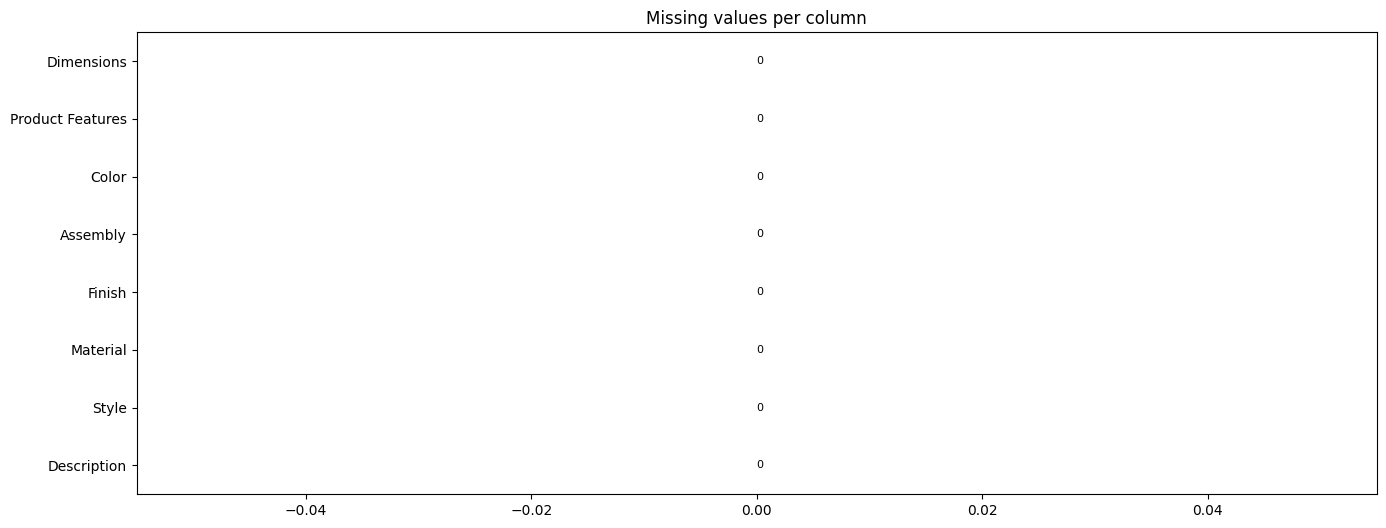

In [87]:
df_drop_cols.isna().sum().to_frame().plot(kind='barh', legend=False, figsize=(16, 6))
for index, value in enumerate(df_drop_cols.isna().sum()):
    plt.text(value, index,
             str(value), va='center', ha='left', fontsize=8)
plt.title("Missing values per column");

In [88]:
# drop all nulls
df_drop_nulls = df_drop_cols.dropna(how='any')
print(df_drop_nulls.shape)
print(df_drop_nulls.isna().sum().sum())

(31335, 8)
0


## Description

In [126]:
# 1. Remove descriptions with length < 50
df_clean_desc = df_drop_nulls[df_drop_nulls['Description'].fillna('').str.len() >= 50]

# 2. Remove descriptions that start with 'warning' (case-insensitive)
df_clean_desc = df_clean_desc[~df_clean_desc['Description'].str.match(r'(?i)^warning', na=False)]

# 3. Remove leading numbering like "1.0_" or "2_"
df_clean_desc['Description'] = df_clean_desc['Description'].str.replace( r'^\d+(\.\d+)?_', '', regex=True)

# 4. Replace all non-letters/digits with a space
df_clean_desc['Description'] = df_clean_desc['Description'].str.replace( r'[^a-zA-Z0-9]+', ' ', regex=True)

# 5. Trim whitespace
df_clean_desc['Description'] = df_clean_desc['Description'].str.strip()

# 6. Remove rows where Description contains "Attention California"
df_clean_desc = df_clean_desc[~df_clean_desc['Description'].str.contains(
    "Attention California", na=False)]

df_clean_desc

(23507, 8)

In [127]:
print("Number of nulls: ", df_clean_desc.isna().sum().sum())

Number of nulls:  0


## Duplicates

In [132]:
df_dup = df_clean_desc.drop_duplicates(keep='first')
print(df_dup.shape)

(7755, 8)


## Tmp saving data

In [134]:
tmp_df = df_dup

tmp_df.to_csv('data/data_cleaned.csv', index=False)